Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.

from __future__ import print_function
import random
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import hashlib
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [3]:
data_root = '.'
train_filename = 'notMNIST_large.tar.gz'
test_filename = 'notMNIST_small.tar.gz'
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small\\A', 'notMNIST_small\\B', 'notMNIST_small\\C', 'notMNIST_small\\D', 'notMNIST_small\\E', 'notMNIST_small\\F', 'notMNIST_small\\G', 'notMNIST_small\\H', 'notMNIST_small\\I', 'notMNIST_small\\J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

We randomly choose an image from each folder. Then, we print the label and display the image.

In [4]:
for label in train_folders:
    image_file = random.sample(os.listdir(label),1)
    img = Image(os.path.join(label, image_file[0]))
    print(label.strip()[-1])
    display(img)

A


B


C


D


E


F


G


H


I


J


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [4]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large\A.pickle already present - Skipping pickling.
notMNIST_large\B.pickle already present - Skipping pickling.
notMNIST_large\C.pickle already present - Skipping pickling.
notMNIST_large\D.pickle already present - Skipping pickling.
notMNIST_large\E.pickle already present - Skipping pickling.
notMNIST_large\F.pickle already present - Skipping pickling.
notMNIST_large\G.pickle already present - Skipping pickling.
notMNIST_large\H.pickle already present - Skipping pickling.
notMNIST_large\I.pickle already present - Skipping pickling.
notMNIST_large\J.pickle already present - Skipping pickling.
notMNIST_small\A.pickle already present - Skipping pickling.
notMNIST_small\B.pickle already present - Skipping pickling.
notMNIST_small\C.pickle already present - Skipping pickling.
notMNIST_small\D.pickle already present - Skipping pickling.
notMNIST_small\E.pickle already present - Skipping pickling.
notMNIST_small\F.pickle already present - Skipping pickling.
notMNIST_small\G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

We check the data by displaying a sample image from each pickle file.

A


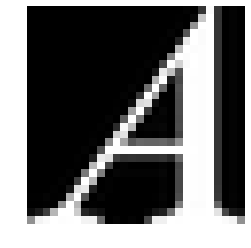

B


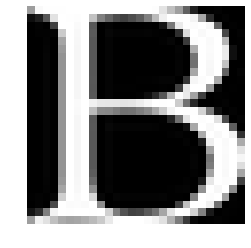

C


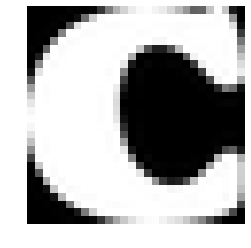

D


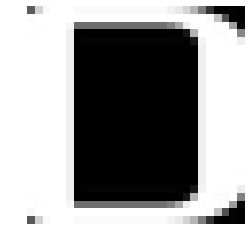

E


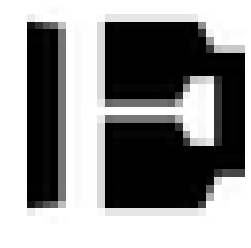

F


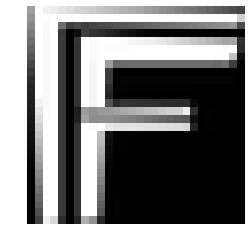

G


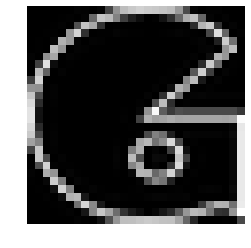

H


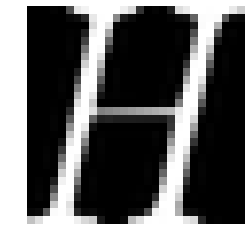

I


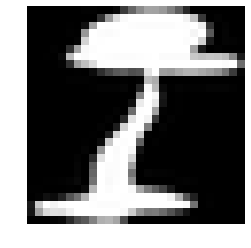

J


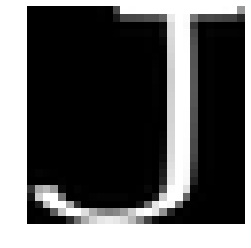

In [6]:
def load_samples_from_pickles(pickle_file_names):
    '''Loads a sample from pickle files. The input is a list containing the addresses of the pickle files.'''
    
    for pickles in pickle_file_names:
        try:
            with open(pickles, 'rb') as file:
                pickle_file = pickle.load(file)
        except Exception as e:
            print('Failed to load pickle: ', e)
        
        print(pickles.strip()[-8])
        sample = pickle_file[np.random.choice(pickle_file.shape[0], replace=False), :, :]
        plt.imshow(sample, cmap='gray')
        plt.axis('off')
        plt.show()

        
load_samples_from_pickles(train_datasets)

Seems the data looks good and the labels match the images.

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

The data is balanced across classes if the __number of images per class__ are almost the same. Also, __the mean and the variance of classes__ should be almost equal as well. 

In [5]:
def stats(pickle_file_names):
    '''Prints the stats of each pickle file.'''
    
    for pickles in pickle_file_names:
        try:
            with open (pickles, 'rb') as file:
                pickle_file = pickle.load(file)
        except Exception as e:
            print('Failed to load pickle: ', e)
        
        print(pickles.strip()[-8])
        print('Number of images in this class:', pickle_file.shape[0])
        print('Mean of the images in this class:', np.mean(pickle_file))
        print('The standard deviation of the images in this class:', np.std(pickle_file))
        
stats(train_datasets)    

A
Number of images in this class: 52909
Mean of the images in this class: -0.12825024
The standard deviation of the images in this class: 0.44312063
B
Number of images in this class: 52911
Mean of the images in this class: -0.0075630303
The standard deviation of the images in this class: 0.45449105
C
Number of images in this class: 52912
Mean of the images in this class: -0.14225811
The standard deviation of the images in this class: 0.43980625
D
Number of images in this class: 52911
Mean of the images in this class: -0.057367794
The standard deviation of the images in this class: 0.45564765
E
Number of images in this class: 52912
Mean of the images in this class: -0.06989899
The standard deviation of the images in this class: 0.45294195
F
Number of images in this class: 52912
Mean of the images in this class: -0.1255833
The standard deviation of the images in this class: 0.44708964
G
Number of images in this class: 52912
Mean of the images in this class: -0.09458135
The standard devia

As shown above, there are almost equal number of images in each class. Furthermore, the mean of each class is close to zero and the standard deviation is close to 0.5 for each class. Therefore, We can conclude that the data is balanced across classes.

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [6]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [7]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

We display some random images from the training dataset. Since the labels are saved using integers, first we define a dictionary which contains the true labels and their representative integers.   
In addition, the mean and the standard deviation of the training set are printed.

Random sample with label G


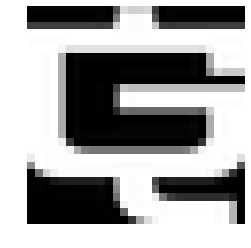

Random sample with label F


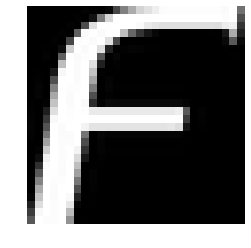

Random sample with label D


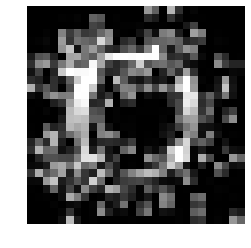

Random sample with label H


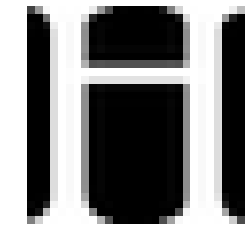

Random sample with label G


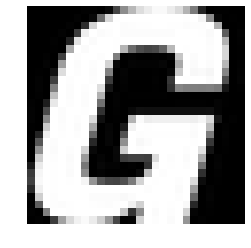

Random sample with label F


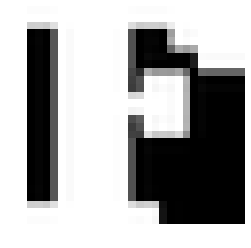

Random sample with label A


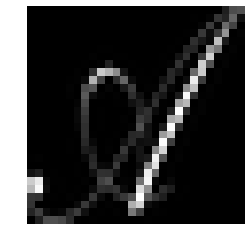

Random sample with label J


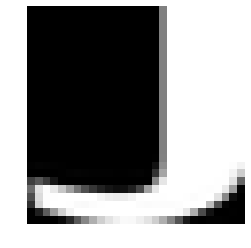

Random sample with label E


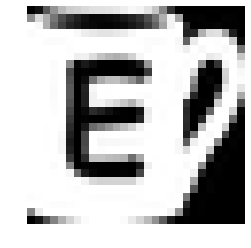

Random sample with label E


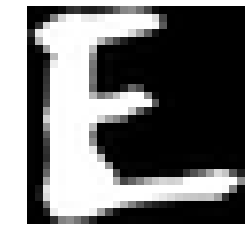

The mean of the training set is -0.08173939
The standard deviation of the training set is 0.45417735


In [10]:
labels_dictionary = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}
def display_samples_with_labels(samples, labels):
    '''Displays random samples and their corresponding labels.'''
    random_indices = np.random.randint(0, samples.shape[0], 10)
    for index in random_indices:
        random_label = labels_dictionary[labels[index]]
        random_img = samples[index, :, :]
        print('Random sample with label', random_label)
        plt.imshow(random_img, cmap = 'gray')
        plt.axis('off')
        plt.show()
    
display_samples_with_labels(train_dataset, train_labels)
print('The mean of the training set is', np.mean(train_dataset))
print('The standard deviation of the training set is', np.std(train_dataset))

It seems that the data and labels match.

Finally, let's save the data for later reuse:

In [8]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [9]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

We use SHA256 Hash to discover duplicates in the training, test and validation sets. Although there is a very small probability of collision (two different files having the same hash), this method is very efficient in detecting duplicities. 

In [10]:
def duplicate_indices(dataset1, dataset2):
    '''Returns an array containing the indices of duplicate images in the two input datasets.'''
    
    hash1 = np.array([hashlib.sha256(file).hexdigest() for file in dataset1])
    hash2 = np.array([hashlib.sha256(file).hexdigest() for file in dataset2])
  
    duplicity = np.isin(hash1, hash2)
    duplicate_indices = np.argwhere(duplicity)
    return duplicate_indices

train_valid_dup = duplicate_indices(train_dataset, valid_dataset)
train_test_dup = duplicate_indices(train_dataset, test_dataset)
valid_test_dup = duplicate_indices(valid_dataset, test_dataset)

print('Number of duplicate images in training and validation sets:', train_valid_dup.shape[0])
print('Number of duplicate images in training and test sets:', train_test_dup.shape[0])
print('Number of duplicate images in validation and test sets:', valid_test_dup.shape[0])

Number of duplicate images in training and validation sets: 3627
Number of duplicate images in training and test sets: 3622
Number of duplicate images in validation and test sets: 153


Now, we remove the duplicities. Note that we keep the __test set__ untouched; we remove duplicate images from __training__ and __validation__ sets only. 

In [11]:
def sanitize(dataset1, labels1, dataset2):
    '''Removes the duplicate images from dataset1 and labels1.'''
    indices = duplicate_indices(dataset1, dataset2)
    dataset1_sanitized = np.delete(dataset1, indices, 0)
    labels1_sanitized = np.delete(labels1, indices, None)
    print('Number of removed items:', indices.shape[0])
    return dataset1_sanitized, labels1_sanitized

train_dataset_sanitized, train_labels_sanitized = sanitize(train_dataset, train_labels, valid_dataset)
train_dataset_sanitized, train_labels_sanitized = sanitize(train_dataset_sanitized, train_labels_sanitized, test_dataset)
valid_dataset_sanitized, valid_labels_sanitized = sanitize(valid_dataset, valid_labels, test_dataset)

Number of removed items: 3627
Number of removed items: 1360
Number of removed items: 153


Now we can verify that the training, validation and test sets are sanitized. 

In [12]:
print('Training dataset:')
print('Dataset array shape:', train_dataset_sanitized.shape)
print('Labels array shape:', train_labels_sanitized.shape)
print('Validation dataset:')
print('Dataset array shape:', valid_dataset_sanitized.shape)
print('Labels array shape:', valid_labels_sanitized.shape)
print('Test dataset:')
print('Dataset array shape:', test_dataset.shape)
print('Labels array shape:', test_labels.shape)

print('Number of duplicate images in training and validation sets:', duplicate_indices(train_dataset_sanitized, valid_dataset_sanitized).shape[0])
print('Number of duplicate images in training and test sets:', duplicate_indices(train_dataset_sanitized, test_dataset).shape[0])
print('Number of duplicate images in validation and test sets:', duplicate_indices(valid_dataset_sanitized, test_dataset).shape[0])

Training dataset:
Dataset array shape: (195013, 28, 28)
Labels array shape: (195013,)
Validation dataset:
Dataset array shape: (9847, 28, 28)
Labels array shape: (9847,)
Test dataset:
Dataset array shape: (10000, 28, 28)
Labels array shape: (10000,)
Number of duplicate images in training and validation sets: 0
Number of duplicate images in training and test sets: 0
Number of duplicate images in validation and test sets: 0


Thus, we have successfully removed the duplicities and sanitized our test and validation sets.  
Now we save the sanitized datasets in a new pickle file for later use.

In [13]:
pickle_file = os.path.join(data_root, 'notMNIST_sanitized.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset_sanitized,
    'train_labels': train_labels_sanitized,
    'valid_dataset': valid_dataset_sanitized,
    'valid_labels': valid_labels_sanitized,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 674660906


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

We train a few Logistic Regression models with 'sag' and 'newton-cg' solvers. Since this is a multiclass classification problem, and our classes are scaled, 'sag' solver may converge faster. We take both the one-versus-rest and multinomial approaches.
  
  
Although there are some hyperparameters to tune (such as regularization factor), we choose to leave their default values unchanged. Hence, the overall performance can be improved by tuning the model.  
  
Since we are not going to tune the model, we use the test set directly to evaluate our model, and we do not use the validation set.

First, we start with 'sag' solver and one-versus-rest approach. 

In [14]:
def max_score(scores_list):
    '''Takes a list of tuples in (sample_size, score) format and prints the maximum score with the corresponding sample size.'''
    if not scores_list:
        raise ValueError('Scores list is empty.')
    max_score_tuple = scores_list[0]
    for tuples in scores_list:
        if tuples[1] > max_score_tuple[1]:
            max_score_tuple = tuples
    print('The maximum score is', max_score_tuple[1], 'for', max_score_tuple[0],'samples.')

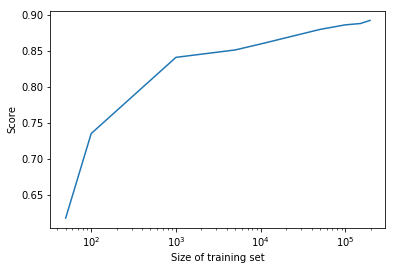

The maximum score is 0.8928 for 195165 samples.


In [17]:
scores = []

for sample_size in [50, 100, 1000, 5000, 10000, 50000, 100000, 150000, train_dataset_sanitized.shape[0]]:
    model = LogisticRegression(multi_class='ovr', solver='sag')
    x_train = train_dataset_sanitized[:sample_size].reshape(sample_size, 28*28)
    y_train = train_labels_sanitized[:sample_size]
    x_test = test_dataset.reshape(test_dataset.shape[0], 28*28)
    y_test = test_labels
    model.fit(x_train, y_train)
    scores.append((sample_size, model.score(x_test, y_test)))

plt.xscale('log')
plt.xlabel('Size of training set')
plt.ylabel('Score')
plt.plot(*zip(*scores))
plt.show()

max_score(scores)

Next, we use 'sag' solver with multinomial approach. 

In [ ]:
scores = []

for sample_size in [50, 100, 1000, 5000, 10000, 50000, 100000, 150000, train_dataset_sanitized.shape[0]]:
    model = LogisticRegression(multi_class='multinomial', solver='sag')
    x_train = train_dataset_sanitized[:sample_size].reshape(sample_size, 28*28)
    y_train = train_labels_sanitized[:sample_size]
    x_test = test_dataset.reshape(test_dataset.shape[0], 28*28)
    y_test = test_labels
    model.fit(x_train, y_train)
    scores.append((sample_size, model.score(x_test, y_test)))

plt.xscale('log')
plt.xlabel('Size of training set')
plt.ylabel('Score')
plt.plot(*zip(*scores))
plt.show()

max_score(scores)

Next, we use 'newton-cg' solver with one-versus-rest approach. 

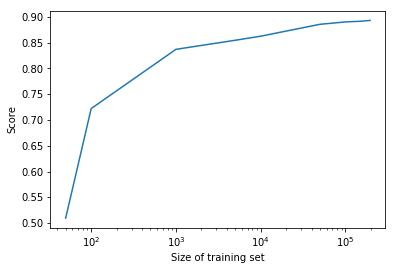

The maximum score is 0.8933 for 195013 samples.


In [12]:
scores = []

for sample_size in [50, 100, 1000, 5000, 10000, 50000, 100000, 150000, train_dataset_sanitized.shape[0]]:
    model = LogisticRegression(multi_class='ovr', solver='newton-cg')
    x_train = train_dataset_sanitized[:sample_size].reshape(sample_size, 28*28)
    y_train = train_labels_sanitized[:sample_size]
    x_test = test_dataset.reshape(test_dataset.shape[0], 28*28)
    y_test = test_labels
    model.fit(x_train, y_train)
    scores.append((sample_size, model.score(x_test, y_test)))

plt.xscale('log')
plt.xlabel('Size of training set')
plt.ylabel('Score')
plt.plot(*zip(*scores))
plt.show()

max_score(scores)

And finally, we use 'newton-cg' solver with multinomial approach. 

In [ ]:
scores = []

for sample_size in [50, 100, 1000, 5000, 10000, 50000, 100000, 150000, train_dataset_sanitized.shape[0]]:
    model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    x_train = train_dataset_sanitized[:sample_size].reshape(sample_size, 28*28)
    y_train = train_labels_sanitized[:sample_size]
    x_test = test_dataset.reshape(test_dataset.shape[0], 28*28)
    y_test = test_labels
    model.fit(x_train, y_train)
    scores.append((sample_size, model.score(x_test, y_test)))

plt.xscale('log')
plt.xlabel('Size of training set')
plt.ylabel('Score')
plt.plot(*zip(*scores))
plt.show()

max_score(scores)